In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
training_set = pd.read_csv("training_indicators5_log.csv")
testing_set = pd.read_csv("testing_indicators5_log.csv")
y_train = training_set[["future 10t return"]].values
y_test = testing_set[["future 10t return"]].values

X_train = training_set[["delta price_t", "delta price_t-1", "delta price_t-2","delta price_t-3",
            "delta price_t-4", "delta price_t-5", "delta price_t-6", "delta price_t-7",
            "order imbalance","macd signal", "log spread", "mid price", "log ADX",
            "RSI", "open interest", "vol"]].values
X_test = testing_set[["delta price_t", "delta price_t-1", "delta price_t-2","delta price_t-3",
            "delta price_t-4", "delta price_t-5", "delta price_t-6", "delta price_t-7",
            "order imbalance","macd signal", "log spread", "mid price", "log ADX",
            "RSI", "open interest", "vol"]].values

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [9]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
X_train = np.delete(X_train, 0, axis=1)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.362
Date:                Sat, 06 Dec 2025   Prob (F-statistic):            0.00168
Time:                        08:50:13   Log-Likelihood:                 18777.
No. Observations:                4245   AIC:                        -3.752e+04
Df Residuals:                    4228   BIC:                        -3.741e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   4.46e-05      3.884      0.0

In [23]:
X_test

array([[-1.83094, -0.86165,  3.11922, ...,  1.38446,  0.36953,  1.87545],
       [-0.96011, -1.83086, -0.86189, ...,  1.05891,  0.37234,  2.22281],
       [ 1.0878 , -0.96   , -1.83101, ...,  1.26912,  0.3984 ,  2.23484],
       ...,
       [-0.7123 ,  1.78987,  1.49086, ...,  0.96062, -3.95085,  0.14167],
       [-0.88042, -0.71219,  1.78938, ...,  0.60825, -3.94351,  0.26571],
       [ 0.6445 , -0.88032, -0.71244, ...,  0.79462, -3.93072,  0.38256]])

In [10]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [11]:
regressor.coef_

array([[-1.30525022e-05, -2.17343360e-05,  3.90340726e-05,
         3.90816485e-05,  1.08269632e-04,  5.80645736e-05,
         5.12354041e-05,  6.13540689e-05,  8.47942816e-05,
        -5.32708888e-05,  1.34834049e-04, -7.29927697e-04,
         4.45049825e-05,  8.53258853e-05,  6.71899669e-04,
        -2.35808137e-05]])

In [12]:
y_pred = regressor.predict(X_test)
y_pred = np.where(np.isinf(y_pred), np.mean(y_test), y_pred)
y_pred = np.where(y_pred>1, np.mean(y_test), y_pred)
y_pred = np.where(y_pred<-1, np.mean(y_test), y_pred)
np.set_printoptions(precision=5)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), axis=1))

[[ 0.00055 -0.00061]
 [ 0.00017  0.0006 ]
 [ 0.00013 -0.00043]
 ...
 [-0.00201 -0.00379]
 [-0.00187 -0.00211]
 [-0.00187 -0.00154]]


In [13]:
y_pred = np.expm1(y_pred)
y_pred

array([[ 0.00055],
       [ 0.00017],
       [ 0.00013],
       ...,
       [-0.002  ],
       [-0.00186],
       [-0.00186]])

In [14]:
import yfinance as yf

ticker = "^TNX"
data = yf.download(ticker, period="1y")

risk_free_rate = data['Close'].iloc[-1] / 100
risk_free_rate = risk_free_rate["^TNX"]/121

/tmp/ipython-input-3789647642.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="1y")
[*********************100%***********************]  1 of 1 completed


In [15]:
risk_free_rate

np.float64(0.0003420661106582515)

In [16]:
data = pd.read_csv("training_data.csv")
df = data.copy()
price_plt = df.iloc[::5, :].reset_index(drop=True)

fee = 0.0005
ATR = training_set["ATR%"]

def backtest(TP, SL):
    position = ""
    initial_price = 0
    total_ret = []

    for i in range(len(y_pred)):
        if position == "":
            if y_pred[i] > 1*fee:
                position = "long"
                initial_price = price_plt["close"][i]

            elif y_pred[i] < -1*fee:
                position = "short"
                initial_price = price_plt["close"][i]

        elif position == "long":
            end_price = price_plt["close"][i]
            pos_return = (end_price * (1 - fee) / initial_price * (1 + fee)) - 1
            if (pos_return >= TP * ATR[i]) or (pos_return <= -SL * ATR[i]):
                position = ""
                total_ret.append(pos_return)

        elif position == "short":
            end_price = price_plt["close"][i]
            pos_return = 1 - (end_price * (1 + fee) / initial_price * (1 - fee))
            if (pos_return >= TP * ATR[i]) or (pos_return <= -SL * ATR[i]):
                position = ""
                total_ret.append(pos_return)

    if len(total_ret) == 0:
        return -np.inf

    ret = np.mean(total_ret)
    vol = np.std(total_ret)
    if vol == 0:
        return -np.inf

    sharpe = ((((1 + ret) ** 121) - 1) - risk_free_rate) / (vol * np.sqrt(121))
    return sharpe

In [17]:
from tqdm import tqdm  # 顯示進度條

best_SR = -np.inf
best_TP, best_SL = 0, 0

TP_range = np.arange(0.5, 3.1, 0.1)
SL_range = np.arange(0.5, 3.1, 0.1)

for TP in tqdm(TP_range, desc="Searching TP"):
    for SL in SL_range:
        SR = backtest(TP, SL)
        if SR > best_SR:
            best_SR = SR
            best_TP, best_SL = TP, SL

Searching TP: 100%|██████████| 26/26 [00:08<00:00,  3.11it/s]


In [18]:
print(f"\nbest TP: {best_TP:.2f}\nbest SL: {best_SL:.2f}\nmax Sharpe Ratio: {best_SR:.4f}")


best TP: 0.80
best SL: 2.80
max Sharpe Ratio: -0.1487


In [19]:
data = pd.read_csv("testing_data.csv")
df = data.copy()
price_plt = df.iloc[::5, :].reset_index(drop=True)
ATR = testing_set["ATR%"]

position = ""
initial_price = 0
end_price = 0
pos_return = 0
total_ret = []

long_entries = []
short_entries = []
exits = []

TP = best_TP
SL = best_SL

for i in range(len(y_pred)):
    if position == "":
        if (y_pred[i] > 1*fee):
            position = "long"
            initial_price = price_plt["close"][i]
            long_entries.append((i, initial_price))

        elif (y_pred[i] < -1*fee):
            position = "short"
            initial_price = price_plt["close"][i]
            short_entries.append((i, initial_price))

    elif position == "long":
        end_price = price_plt["close"][i]
        pos_return = (end_price * (1-fee) / initial_price * (1+fee)) - 1
        if (pos_return >= TP*ATR[i]) or (pos_return <= -SL*ATR[i]):
            position = ""
            initial_price = 0
            total_ret.append(pos_return)
            exits.append((i, end_price))

    elif position == "short":
        end_price = price_plt["close"][i]
        pos_return = 1 - (end_price  * (1+fee)/ initial_price * (1-fee))
        if (pos_return >= TP*ATR[i]) or (pos_return <= -SL*ATR[i]):
            position = ""
            initial_price = 0
            total_ret.append(pos_return)
            exits.append((i, end_price))


In [20]:
def Sharp(total_ret):
    ret = np.mean(total_ret)
    vol = np.std(total_ret)

    N = len(total_ret)
    if N == 0 or vol == 0:
        return np.nan

    T_years = (len(data) * 5) / (60 * 24 * 365)

    # 年化
    ret_annual = (1 + ret)**(1/T_years) - 1
    vol_annual = vol * (1 / np.sqrt(T_years))

    return float((ret_annual - risk_free_rate) / vol_annual)

In [21]:
print("sharp ratio:", Sharp(total_ret))

sharp ratio: -0.061724072324013134


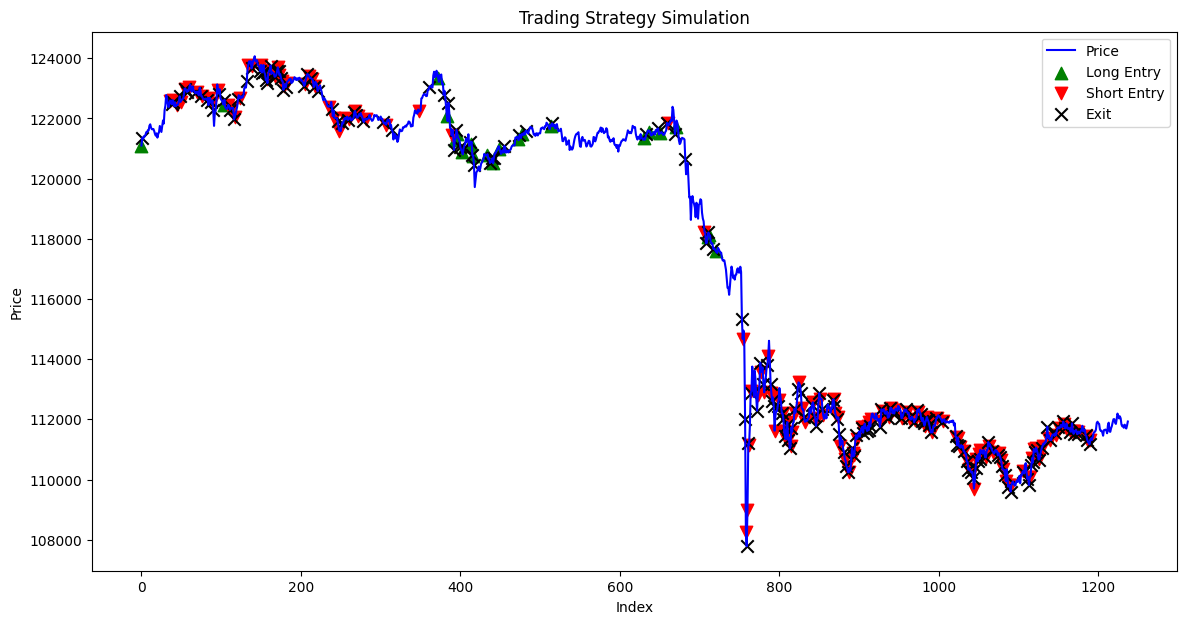

In [22]:
plt.figure(figsize=(14,7))
plt.plot(price_plt["close"], label="Price", color="blue")

plt.scatter([x[0] for x in long_entries], [x[1] for x in long_entries],
            color="green", marker="^", s=80, label="Long Entry")

plt.scatter([x[0] for x in short_entries], [x[1] for x in short_entries],
            color="red", marker="v", s=80, label="Short Entry")

plt.scatter([x[0] for x in exits], [x[1] for x in exits],
            color="black", marker="x", s=80, label="Exit")

plt.legend()
plt.title("Trading Strategy Simulation")
plt.xlabel("Index")
plt.ylabel("Price")
plt.show()